In [25]:
import json
from collections import defaultdict
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import utils
import plot_utils

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [26]:
def load_public_dataset(tournament='World_Cup'):
    """
    Load the json files with the matches, events, players and competitions
    
    Parameters
    ----------
    data_folder : str, optional
        the path to the folder where json files are stored.
        
    tournaments : list, optional
        the list of tournaments to load. 
        
    Returns
    -------
    tuple
        a tuple of four dictionaries, containing matches, events, players and competitions
        
    """
    # loading the matches and events data
    matches, events = {}, {}
    with open('events/events_%s.json' %tournament) as json_data:
        events = json.load(json_data)
    with open('matches/matches_%s.json' %tournament) as json_data:
        matches = json.load(json_data)
    
    match_id2events = defaultdict(list)
    match_id2match = defaultdict(dict)
    for event in events:
        match_id = event['matchId']
        match_id2events[match_id].append(event)
                                         
    for match in matches:
        match_id = match['wyId']
        match_id2match[match_id] = match

    # loading the players data
    with open('players.json') as json_data:
        players = json.load(json_data)
    
    player_id2player = defaultdict(dict)
    for player in players:
        player_id = player['wyId']
        player_id2player[player_id] = player
    
    # loading the competitions data
    teams={}
    with open('teams.json') as json_data:
        teams = json.load(json_data)
    team_id2team = defaultdict(dict)
    for team in teams:
        team_id = team['wyId']
        team_id2team[team_id] = team
    
    return match_id2match, match_id2events, player_id2player, team_id2team

In [27]:
def passing_networks(match_id=2057954):
    """
    Construct the passing networks of the teams in the match.
    
    Parameters
    ----------
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        the two constructed networks, as networkx objects.
    """
    
    # take the names of the two teams of the match
    match_label = match_id2match[match_id]['label']
    team1_name = match_label.split('-')[0].strip()
    team2_name = match_label.split('-')[1].split(',')[0].strip()
    
    # take all the events of the match
    match_events = []
    for event in match_id2events[match_id]:
        if event['eventName'] == 'Pass':
            match_events.append(event)

    match_events_df = pd.DataFrame(match_events)
    first_half_max_duration = np.max(match_events_df[match_events_df['matchPeriod'] == '1H']['eventSec'])

    # sum 1H time end to all the time in 2H
    for event in match_events:
        if event['matchPeriod'] == '2H':
            event['eventSec'] += first_half_max_duration
    
    team2pass2weight = defaultdict(lambda: defaultdict(int))
    for event, next_event, next_next_event in zip(match_events, match_events[1:], match_events[2:]):
        try:
            if event['eventName'] == 'Pass' and 1801 in [tag['id'] for tag in event['tags']]:
                sender = player_id2player[event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                # case of duel
                if next_event['eventName'] == 'Duel':
                    # if the next event of from a playero of the same team
                    if next_event['teamId'] == event['teamId']:
                        receiver = player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                    else:
                        receiver = player_id2player[next_next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                else:  # any other event 
                    if next_event['teamId'] == event['teamId']:
                        receiver = player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
        except KeyError:
            pass
    # crete networkx graphs
    G1, G2 = nx.DiGraph(team=team1_name), nx.DiGraph(team=team2_name)
    for (sender, receiver), weight in team2pass2weight[team1_name].items():
        G1.add_edge(sender, receiver, weight=weight)
    for (sender, receiver), weight in team2pass2weight[team2_name].items():
        G2.add_edge(sender, receiver, weight=weight)    

    #adicionar lista de pares de redes aqui
    
    return G1, G2

In [28]:
def pith_pos_to_dict(data):

    aux = data[['playerId', 'y', 'x']]
    aux['nome'] = aux['playerId'].apply(lambda p: player_id2player[p]['shortName'].encode('ascii', 'strict').decode('unicode-escape'))

    res = dict(zip(aux['nome'], zip(aux['x'], aux['y'])))

    return res

In [29]:
def plot_passing_networks(G1, G2, df_pos):
    """
    Plot the two passing networks in input.
    
    Parameters
    ----------
    G1 : networkx object
        the object representing the first network
        
    G2 : networkx object
        the object representing the second network
    """

    player_pos = pith_pos_to_dict(df_pos)

    #fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

    fig, ax1 = plot_utils.pitch()
    fig, ax2 = plot_utils.pitch()
    
    nome2degree = dict(G1.degree)
    nx.draw(G1, pos=player_pos, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()], 
            node_color='red', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75, ax=ax1)
    ax1.set_title('Time 1')
    ax1.set_xlim([0, 100])
    ax1.set_ylim([0, 100])
    ax1.set_axis_on()

    
    nome2degree = dict(G2.degree)
    nx.draw(G2, pos=player_pos, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()],
            node_color='blue', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75, ax=ax2)
    ax2.set_title('Time 2')
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0, 100])
    ax2.set_axis_on()
    
    plt.show()

In [30]:
match_id2match, match_id2events, player_id2player, team_id2team = load_public_dataset()
matches = pd.read_json('matches\matches_World_Cup.json')
events = pd.read_json('events\events_World_Cup.json')

events['tags'] = events['tags'].map(utils.converting_tags)

In [31]:
passes = events[(events['eventName'] == 'Pass') & (events['tags'].apply(lambda x: (1801 in x)))]

coords = passes['positions'].apply(pd.Series)[0].apply(pd.Series)
passes = passes.join(coords)
passes = passes.drop(['positions'], axis = 1)

pitch_coords = passes.groupby(['matchId', 'teamId', 'playerId']).agg(y=('y','mean'), x=('x','mean'))
pitch_coords = pitch_coords.reset_index()

In [32]:
net_list = defaultdict(tuple)
for matchID in match_id2match.keys():    
    G1, G2 = passing_networks(match_id = matchID)
    par = (G1, G2)
    net_list[matchID] = par

C:\Users\eduar\AppData\Local\Temp/ipykernel_19648/2647024513.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



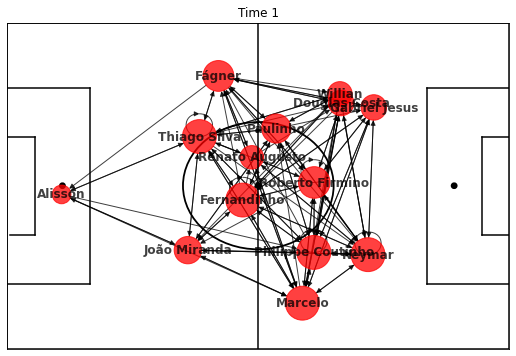

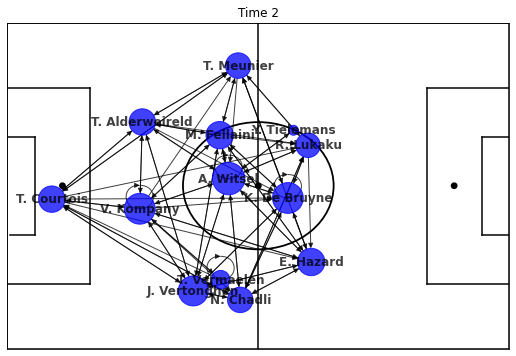

In [9]:
plot_passing_networks(net_list[2058011][0], net_list[2058011][1], pitch_coords[pitch_coords['matchId'] == 2058011])

In [39]:
#degree_centrality
def degree_centrality(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append(np.mean(list(nx.degree_centrality(net[0]).values())))
        data1.append(np.mean(list(nx.degree_centrality(net[1]).values())))

    return pd.DataFrame(list(zip(data0, data1)), columns=['degree_centrality_T1', 'degree_centrality_T2'])


#betwenness_centrality
def betwenness_centrality(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append(np.mean(list(nx.betweenness_centrality(net[0]).values())))
        data1.append(np.mean(list(nx.betweenness_centrality(net[1]).values())))

    return pd.DataFrame(list(zip(data0, data1)), columns=['betweenness_centrality_T1', 'betweenness_centrality_T2'])

#closeness_centrality
def closeness_centrality(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append(np.mean(list(nx.closeness_centrality(net[0]).values())))
        data1.append(np.mean(list(nx.closeness_centrality(net[1]).values())))

    return pd.DataFrame(list(zip(data0, data1)), columns=['closeness_centrality_T1', 'closeness_centrality_T2'])

#eigenvalue_centrality
def eigenvector_centrality(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append(np.mean(list(nx.eigenvector_centrality(net[0]).values())))
        data1.append(np.mean(list(nx.eigenvector_centrality(net[1]).values())))

    return pd.DataFrame(list(zip(data0, data1)), columns=['eigenvector_centrality_T1', 'eigenvector_centrality_T2'])

#clustering coefficient
def clustering_coefficient(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append((nx.average_clustering(net[0])))
        data1.append((nx.average_clustering(net[1])))

    return pd.DataFrame(list(zip(data0, data1)), columns=['clustering_T1', 'clustering_T2'])

#average shortest path lenght
def avg_shortest_path(netlist):
    data0 = []
    data1 = []
    for net in netlist.values():
        data0.append((nx.average_shortest_path_length(net[0])))
        data1.append((nx.average_shortest_path_length(net[1])))

    return pd.DataFrame(list(zip(data0, data1)), columns=['avg_shortest_path_T1', 'avg_shortest_path_T2'])

#position centroid
def centroid(netlist):
    centroid = pitch_coords.groupby(['matchId', 'teamId']).agg(y=('y','mean'), x=('x','mean')).reset_index()
    centroid = centroid.rename(columns={"y": "centroid_y", "x": "centroid_x"})
    
    return centroid



In [42]:
df = matches[['wyId']]
df = df.rename(columns={'wyId':'matchID'})



home_l = []
away_l = []

for match in matches['teamsData']:
    t0 = list(match.values())[0]
    t1 = list(match.values())[1]

    if t0['side'] == 'home':
        home_l.append(t0['teamId'])
        away_l.append(t1['teamId'])  
    else: 
        away_l.append(t0['teamId'])
        home_l.append(t1['teamId'])

df['team1_ID'] = home_l
df['team2_ID'] = away_l

closeness = closeness_centrality(net_list)
degree = degree_centrality(net_list)
betwenness = betwenness_centrality(net_list)
eigenvector = eigenvector_centrality(net_list)
clustering = clustering_coefficient(net_list)
shortest_path = avg_shortest_path(net_list)
df_centroid = centroid(net_list)

df = df.join(closeness)
df = df.join(degree)
df = df.join(betwenness)
df = df.join(eigenvector)
df = df.join(clustering)
df = df.join(shortest_path)

df = df.merge(df_centroid, how='left', left_on=['matchID', 'team1_ID'], right_on=['matchId', 'teamId']).drop(['matchId', 'teamId'], axis=1)
df = df.merge(df_centroid, how='left', left_on=['matchID', 'team2_ID'], right_on=['matchId', 'teamId']).drop(['matchId', 'teamId'], axis=1)
df = df.rename(columns={"centroid_y_x": "centroid_y_T1", "centroid_x_x": "centroid_x_T1"})
df = df.rename(columns={"centroid_y_y": "centroid_y_T2", "centroid_x_y": "centroid_x_T2"})

df['winner'] = np.where((matches['winner'] == df['team1_ID']), 1, 0)

df


,matchID,team1_ID,team2_ID,closeness_centrality_T1,closeness_centrality_T2,degree_centrality_T1,degree_centrality_T2,betweenness_centrality_T1,betweenness_centrality_T2,eigenvector_centrality_T1,eigenvector_centrality_T2,clustering_T1,clustering_T2,avg_shortest_path_T1,avg_shortest_path_T2,centroid_y_T1,centroid_x_T1,centroid_y_T2,centroid_x_T2,winner
0,2058017,4418,9598,0.657888,0.721444,0.967033,1.256410,0.046245,0.039044,0.250619,0.262052,0.681110,0.778498,1.554945,1.429487,49.671026,43.666213,50.493416,52.090271,1
1,2058016,5629,2413,0.737929,0.770628,1.263736,1.373626,0.032051,0.026557,0.256636,0.260992,0.723817,0.795799,1.384615,1.318681,45.295257,47.387378,46.125344,52.884781,1
2,2058015,9598,2413,0.717352,0.729162,1.219780,1.252747,0.037546,0.033425,0.250509,0.257887,0.774894,0.730676,1.450549,1.401099,45.975114,51.304158,48.171446,46.581864,1
3,2058014,4418,5629,0.660171,0.743380,1.051282,1.269231,0.051282,0.034965,0.254585,0.263569,0.732744,0.771655,1.564103,1.384615,48.452660,50.427829,49.478704,52.885640,1
4,2058012,14358,9598,0.662708,0.755900,1.028571,1.333333,0.040659,0.027473,0.250044,0.247488,0.605364,0.762160,1.528571,1.357143,50.169707,46.813374,44.279879,48.874782,0
5,2058013,7047,2413,0.650194,0.668593,1.032967,1.164835,0.036630,0.033425,0.248292,0.244224,0.630296,0.683876,1.368132,1.329670,47.724832,46.054695,48.451039,51.954879,0
6,2058011,6380,5629,0.746186,0.693287,1.329670,1.166667,0.030220,0.044289,0.257667,0.258403,0.744290,0.648905,1.362637,1.487179,53.506792,52.492459,47.617150,42.605661,0
7,2058010,15670,4418,0.660797,0.669339,1.065934,1.098901,0.045788,0.046703,0.252023,0.247014,0.655723,0.684963,1.549451,1.560440,54.716057,50.596435,56.496221,48.628540,0
8,2058009,12430,2413,0.709143,0.717607,1.200000,1.180952,0.034432,0.033333,0.244019,0.242571,0.774590,0.737543,1.447619,1.433333,50.624037,46.789052,43.730840,48.325821,0
9,2058008,7047,6697,0.622706,0.725784,0.879121,1.192308,0.054487,0.037296,0.244024,0.264338,0.731067,0.773490,1.653846,1.410256,51.027102,48.441478,47.655799,53.751720,1
